In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
from matplotlib.colors import Normalize
from qutip import *
import random
from matplotlib.animation import FuncAnimation
import collections
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import time
import threading

## 想定するqubit系

以下のように, 2つの非調和振動子Q0, Q1がXX結合したハミルトニアンを仮定する:
$$
\begin{align}
\hat{H}
&= \hat{H}_0 + \hat{H}_1 + \hat{H}_{\rm int} + \hat{H}_{\rm d0} + \hat{H}_{\rm d1}\\
\hat{H}_i / \hbar
&= \omega_{{\rm q}i}\hat{a}_i^\dagger\hat{a}_i + \frac{\alpha_i}{2}\hat{a}_i^\dagger\hat{a}_i^\dagger\hat{a}_i\hat{a}_i
= 2\pi f_{{\rm q}i} \hat{a}_i^\dagger\hat{a}_i + \frac{2\pi f_{{\rm anharm}i}}{2}\hat{a}_i^\dagger\hat{a}_i^\dagger\hat{a}_i\hat{a}_i
\quad (i=0,1)\\
\hat{H}_{{\rm d}i} / \hbar
&= \varOmega_i\cos(\omega_{{\rm d}i}t + \phi_i)(\hat{a}_i^\dagger + \hat{a}_i)
= 2\pi f_{{\rm rabi}i}\cos(2\pi f_{{\rm d}i}t + \phi_i)(\hat{a}_i^\dagger + \hat{a}_i) \quad (i=0,1)\\
\hat{H}_{\rm int} / \hbar
& = g(\hat{a}_0\hat{a}_1^\dagger + {\rm H.c.}) = 2\pi f_g(\hat{a}_0\hat{a}_1^\dagger + {\rm H.c.}).
\end{align}
$$
このハミルトニアンの下3順位までを考慮する. 

緩和は縦緩和と純位相緩和を仮定する. 
状態の時間発展は以下のマスター方程式で表される: 
$$
\frac{\mathrm{d}\hat{\rho}}{\mathrm{d}t}
=
-\frac{\mathrm{i}}{\hbar}
[\hat{H}/\hbar,\hat{\rho}]
+\frac{1}{2}\sum_j
(2\hat{L}_j\hat{\rho}\hat{L}_j^\dagger - \hat{L}_j^\dagger\hat{L}_j\hat{\rho}-\hat{\rho}\hat{L}_j^\dagger\hat{L}_j)
$$
ここで$\hat{L}_{{\rm l}i}=\sqrt{\gamma_i}\hat{a}_i\ (i=0,1)$はレート$\gamma_i$の縦緩和, $\hat{L}_{{\rm p}i}=\sqrt{2\gamma_{{\rm p}i}}\hat{a}_i^\dagger\hat{a}_i\ (i=0,1)$はレート$\gamma_{{\rm p}i}$の純位相緩和に対応するリンドブラッド演算子である. 

In [3]:
"""qubitパラメータ"""

f_q = 7500
f_anharm = -380


"""演算子の定義"""

N = 3 # 非調和3準位系を考える

a = destroy(N) # 消滅演算子
P0 = basis(N,0) * basis(N,0).dag() # |0><0|
P1 = basis(N,1) * basis(N,1).dag() # |1><1|
P2 = basis(N,2) * basis(N,2).dag() # |2><2|


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = 2*np.pi * f_q * a.dag() * a + (2*np.pi*f_anharm / 2) * a.dag() * a.dag() * a * a
# 駆動ハミルトニアンの時間無依存部分
H_d = 2*np.pi * (a + a.dag())

f_d = 7500

# 全体のハミルトニアン
def H_tot(w):
    H_tot = [H_q, [H_d, np.real(w)]] 
    return H_tot


"""リンドブラッド演算子"""

gamma = 0.1
L1 = np.sqrt(gamma) * a # 縦緩和

gamma_p = 1
L2 = np.sqrt(2*gamma_p) * a.dag() * a # 純位相緩和


"""初期状態"""

ini_state = basis(N,0)   #　|0>

In [9]:
ini = 0
state = ini_state
s_input = []
def input_manager():
    global ts, s_input, qstates, ini,state
    while(1):
        ts+=5
        time.sleep(0.001)
        if (ts%10 == 0):
            if(len(s_input)>100):
                t_list = np.linspace(s_input[0][0], s_input[100][0], 100+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(100):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[100:]
                state = result.states[-1]
                
            elif(len(s_input)>10):
                t_list = np.linspace(s_input[0][0], s_input[10][0], 10+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(10):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[10:]
                state = result.states[-1]
                
            elif(len(s_input)>1):
                t_list = np.linspace(s_input[0][0], s_input[1][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
                
            elif(len(s_input)==1):
                t_list = np.linspace(s_input[0][0]-3.3333333333333335e-05,s_input[0][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
            
            if(ini==1):
                ini=0
                state = ini_state
                qstates.append([0,0,state[0][0][0]*state.dag()[0][0][0]\
                    ,state[1][0][0]*state.dag()[0][0][1]\
                    ,state[2][0][0]*state.dag()[0][0][2]])

def initialize():
    global ini
    ini = 1

In [12]:
print(state)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.03252888+0.06096533j]
 [-0.98831018+0.09643901j]
 [ 0.00497633+0.09561824j]]


In [13]:
# R(X/Y) gate
ts = 0
f_rabi = 50
f_d = 7500
phi = 0
s_input = []

samples = 300
ts_f = 0.01 # 0.01 us = 10 ns
I = 0
Q = 1
for i in range(samples+1):
    s_input.append([ts+i*(ts_f/samples), f_rabi*(I*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi)),f_rabi*(Q*np.cos(2*np.pi*i*f_d*(ts_f/samples) + phi))])

In [11]:
ts = 0
threading.Thread(target=input_manager).start()

In [ ]:
s_input[2]

In [ ]:
#s_input time - I - Q
test = [ts+i*(ts_f/samples), f_rabi*(I*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi)),f_rabi*(Q*np.cos(2*np.pi*i*f_d*(ts_f/samples) + phi))]
print(test[0])
print(test[1]+test[2])

In [ ]:
# R(X/Y) gate
ts = 0
f_rabi = 50
f_d = 7500
phi = 0
s_input = []

samples = 1000
ts_f = 0.01
I = 1
Q = 0
for i in range(samples+1):
    s_input.append([f_rabi*(I*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi)+Q*np.cos(2*np.pi*i*f_d*(ts_f/samples) + phi)),ts+i*(ts_f/samples)])
    #s_input.append([f_rabi*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi),ts+i*(ts_f/samples)])
state = ini_state            
t_list = np.linspace(ts+0, ts+ts_f, len(s_input))
w = np.zeros(len(t_list), dtype=np.float32)
for x in range(len(t_list)):
    w[x] = s_input[x][0]
result = sesolve(H_tot(w), state, t_list)
s_input = s_input[len(t_list):]
state = result.states[-1]
print(state)

In [ ]:
initialize()

In [ ]:
qstates[9][1]

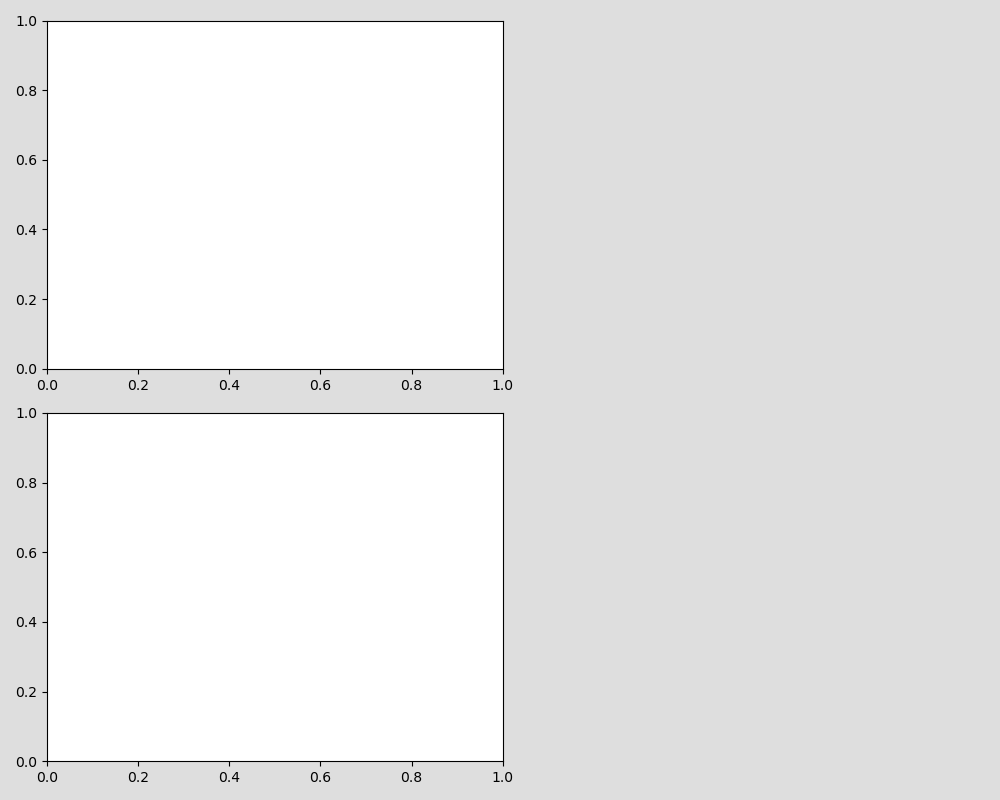

In [4]:
%matplotlib widget

# function to update the data
qstates = []
qsave = (0, 0, 0)
count = 0
#fig = plt.figure()
fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

def my_function(i):
    # input control
    global qstates, count, qsave
    
    ctrl_input_i.popleft()
    ctrl_input_q.popleft()
    
    q0_state0.popleft()
    q0_state1.popleft()
    q0_state2.popleft()
    
    if len(qstates)>=3:
        ctrl_input_i.append(qstates[0][0])
        ctrl_input_q.append(qstates[0][1])
        
        q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])
        
        qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[3:]
    else:
        ctrl_input_i.append(0)
        ctrl_input_q.append(0)
    
        q0_state0.append(qsave[0])
        q0_state1.append(qsave[1])
        q0_state2.append(qsave[2])
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Qubit State")
    ax2.set_title("Input Control")
 
    # plot input1    
    ax1.set_ylim(-0.3,1.3)
    ax1.plot(alist/10,q0_state0,color="blue", label="p0")
    ax1.scatter(alist[-1]/10, q0_state0[-1],color="blue")

    ax1.plot(alist/10,q0_state1,color="red", label="p1")
    ax1.scatter(alist[-1]/10, q0_state1[-1],color="red")
    
    ax1.plot(alist/10,q0_state2,color="green", label="p2")
    ax1.scatter(alist[-1]/10,q0_state2[-1],color="green")
    ax1.legend(loc=(0.05, 0.75))
    ax1.set_xlabel("time[ns]", {"fontsize":15})
    ax1.set_ylabel("probability", {"fontsize":15})
    
    # plot input2
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-60,60)
    ax2.plot(alist/10, ctrl_input_i,color="blue", label="I")
    ax2.scatter(alist[-1]/10, ctrl_input_i[-1],color="blue")
    
    ax2.plot(alist/10, ctrl_input_q,color="red", label="Q")
    ax2.scatter(alist[-1]/10, ctrl_input_q[-1],color="red")
    
    ax2.set_xlabel("time[ns]", {"fontsize":15})
    ax2.set_ylabel("power[?]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))

# start collections with zeros
ctrl_input_i = collections.deque(np.zeros(100))
ctrl_input_q = collections.deque(np.zeros(100))
q0_state0 = collections.deque(np.zeros(100))
q0_state1 = collections.deque(np.zeros(100))
q0_state2 = collections.deque(np.zeros(100))

# define and adjust figure
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0], facecolor="white")   

# animate

ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

In [ ]:
f_rabi = 1000
#result = mesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list, [L1, L2], [P0, P1, P2]) 
result = sesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list) 
for x in range(100):
    #ctrl_in.append([x,result.expect[0][x],result.expect[1][x],result.expect[2][x]])
    ctrl_in.append([x,(result.states[x]*result.states[x].dag())[0][0][0].real,(result.states[x]*result.states[x].dag())[1][0][0].real,(result.states[x]*result.states[x].dag())[2][0][0].real])
    ctrl__.append([x,w[x]])

#state_2 = P0*result.expect[0][-1]+P1*result.expect[1][-1]+P2*result.expect[2][-1]
state_2 = result.states[-1]

w = np.zeros(100, dtype=np.float32)
for i in range(100):
    w[i] = np.cos(2*np.pi*i*(f_d-2000)*2.00e-05)
#result = mesolve(H_tot(f_rabi, f_d, phi,w), state_2, t_list, [L1, L2], [P0, P1, P2])
result = sesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list) 
for x in range(100):
    #ctrl_in.append([x,result.expect[0][x],result.expect[1][x],result.expect[2][x]])
    ctrl_in.append([x,(result.states[x]*result.states[x].dag())[0][0][0].real,(result.states[x]*result.states[x].dag())[1][0][0].real,(result.states[x]*result.states[x].dag())[2][0][0].real])
    ctrl__.append([x,w[x]])

#state_3 = P0*result.expect[0][-1]+P1*result.expect[1][-1]+P2*result.expect[2][-1]
state_3 = result.states[-1]
for i in range(100):
    w[i] = np.cos(2*np.pi*i*(f_d)*2.00e-05)
#result = mesolve(H_tot(f_rabi, f_d, phi,w), state_3, t_list, [L1, L2], [P0, P1, P2])
result = sesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list) 

for x in range(100):
    #ctrl_in.append([x,result.expect[0][x],result.expect[1][x],result.expect[2][x]])
    ctrl_in.append([x,(result.states[x]*result.states[x].dag())[0][0][0].real,(result.states[x]*result.states[x].dag())[1][0][0].real,(result.states[x]*result.states[x].dag())[2][0][0].real])
    ctrl__.append([x,w[x]])

In [ ]:
qsave

In [ ]:
len(qstates)

In [ ]:
qsave = 1.77,3.99,4

In [ ]:
threading.Thread(target=input_manager).start()

In [ ]:
def input_manager():
    global s_input0, s_input1, qstates
    ts = 0
    state = ini_state
    while(1):
        ts+=1
        time.sleep(0.001)
        if (ts%10 == 0):
            if(len(s_input)>=100):
                t_list = np.linspace(ts+0, ts+0.002, 100+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][0]
                result = sesolve(H_tot(f_rabi, f_d, phi,w), state, t_list)
                for i in range(100):
                    qstates.append([s_input[i][0],s_input[i][1],result.states[i][0][0][0],result.states[i][1][0][0],result.states[i][2][0][0]])
                s_input = s_input[100:]
                state_ = result.states[-1]
            elif(len(s_input)>=10):
                t_list = np.linspace(ts+0, ts+0.0002, 10+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][0]
                result = sesolve(H_tot(f_rabi, f_d, phi,w), state, t_list)
                for i in range(10):
                    qstates.append([s_input[i][0],s_input[i][1],result.states[i][0][0][0],result.states[i][1][0][0],result.states[i][2][0][0]])
                s_input = s_input[10:]
                state_ = result.states[-1]
            elif(len(s_input)>=1):
                t_list = np.linspace(ts+0, ts+0.0002, 1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][0]
                result = sesolve(H_tot(f_rabi, f_d, phi,w), state, t_list)
                qstates.append([s_input[0][0],s_input[0][1],result.states[1][0][0][0],result.states[1][1][0][0],result.states[1][2][0][0]])
                s_input = s_input[1:]
                state_ = result.states[-1]

In [ ]:
f_rabi = 1000
s_input = []
w = np.zeros(1999, dtype=np.float32)
for i in range(1999):
    s_input.append([np.cos(2*np.pi*i*f_d*2.00e-05),np.sin(2*np.pi*i*f_d*2.00e-05)])

In [ ]:
#2qubit

"""qubitパラメータ"""

f_q = [7500, 8300]
f_anharm = [-380, -400]
f_g = -10


"""演算子の定義"""

N = 3 # 非調和3準位系を考える

a0 = tensor(destroy(N), qeye(N)) # Q1の消滅演算子
a1 = tensor(qeye(N), destroy(N)) # Q2の消滅演算子
a = [a0, a1]

P0_0 = tensor(basis(N,0) * basis(N,0).dag(), qeye(N)) # |0><0|
P1_0 = tensor(basis(N,1) * basis(N,1).dag(), qeye(N)) # |1><1|
Z_0 = P0_0 - P1_0 #sigma_z
X_0 = tensor(basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_x
Y_0 = tensor(1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_y

P0_1 = tensor(qeye(N), basis(N,0) * basis(N,0).dag()) # |0><0|
P1_1 = tensor(qeye(N), basis(N,1) * basis(N,1).dag()) # |1><1|
Z_1 = P0_1 - P1_1 #sigma_z
X_1 = tensor(qeye(N), basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag()) #sigma_x
Y_1 = tensor(qeye(N), 1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag()) #sigma_y

P0 = [P0_0, P0_1]
P1 = [P1_0, P1_1]
Z = [Z_0, Z_1]
X = [X_0, X_1]
Y = [Y_0, Y_1]


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = []
for i in range(2):
    H_qi = 2*np.pi * f_q[i] * a[i].dag() * a[i] + (2*np.pi*f_anharm[i] / 2) * a[i].dag() * a[i].dag() * a[i] * a[i]
    H_q.append(H_qi)

# 駆動ハミルトニアンの時間無依存部分
H_d = []
for i in range(2):
    H_di = 2*np.pi * (a[i].dag() + a[i])
    H_d.append(H_di)

# 相互作用ハミルトニアン
H_int = 2*np.pi * f_g *(a[0] * a[1].dag() + a[0].dag() * a[1])

t_list = np.linspace(0, 0.2, 10001) # 時間リスト

# 全体のハミルトニアン
def H_tot(f_rabi, f_d, phi, t_list):
    H_tot = [H_q[0] + H_q[1] + H_int, 
             [H_d[0], np.real(f_rabi[0] * np.exp(1j * (2*np.pi * f_d[0] * t_list + phi[0])))], 
             [H_d[1], np.real(f_rabi[1] * np.exp(1j * (2*np.pi * f_d[1] * t_list + phi[1])))]
            ] 
    return H_tot


"""リンドブラッド演算子"""

gamma = [0.1, 0.1]
L_l = []
for i in range(2):
    L_li = np.sqrt(gamma[i]) * a[i] # 縦緩和
    L_l.append(L_li)

gamma_p = [0.3, 0.3]
L_p = []
for i in range(2):
    L_pi = np.sqrt(2*gamma_p[i]) * a[i].dag() * a[i] # 純位相緩和
    L_p.append(L_pi)


"""初期状態"""

ini_state = tensor(basis(N,0), basis(N,0))   #　|0>|0>

In [ ]:
H_q

In [ ]:
H_d

In [ ]:
"""関数, クラスの定義"""


class StateEvo:
    """
    量子状態の時間発展を記述するクラス
    """

    def __init__(self, state, time=0):
        """
        コンストラクタ.
        インスタンスはstateとtimeの2つの内部変数を内蔵する.
        """
        self.state = state # 現在の量子状態
        self.time = time # 現在の時刻

    def rect_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さの矩形パルスの包絡線の複素振幅波形リスト
        """
        func = np.array([A * np.exp(1j * phi) for i in t_list])
        return func
        
    def drag_evlp(A, R, phi, t_list):
        """
        Parameters
        ----------
        A : 最適化DRAG振幅
        R : 最適化DRAG IQ比
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのDrag1回分の包絡線の複素振幅リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]
        func = A * (1 - np.cos(2*np.pi * t_list_from_zero / t_total_length) \
                    + 1j * R * np.sin(2*np.pi * t_list_from_zero / t_total_length)) \
                * np.exp(1j * phi)
        return func
    
    def cos_rise_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのcos_rise立ち上がりの包絡線の複素振幅波形リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        func = A * (1 - np.cos(np.pi * t_list_from_zero / t_total_length)) / 2 * np.exp(1j * phi)
        
        return func
    
    def cos_fall_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのcos_rise立ち上がりの包絡線の複素振幅波形リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        func = A * (1 - np.cos(np.pi * (t_list_from_zero-t_total_length) / t_total_length)) / 2 * np.exp(1j * phi)
        
        return func

    def raisedcos_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのレイズドコサイン・フラットトップパルスの包絡線の複素振幅波形リスト
        """
        t_rise = 0.02 # 立ち上がり・立ち下がり時間（決め打ち）

        func = (0 + 0j) * t_list #リストの初期化
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        cdtn1 = (t_list_from_zero < t_rise)
        cdtn2 = (t_rise <= t_list_from_zero) & (t_list_from_zero < t_total_length - t_rise)
        cdtn3 = (t_total_length - t_rise <= t_list_from_zero) & (t_list_from_zero < t_total_length)

        func[cdtn1] = A * (1 - np.cos(np.pi * t_list_from_zero[cdtn1] / t_rise)) / 2 * np.exp(1j * phi)
        func[cdtn2] = A * np.exp(1j * phi)    
        func[cdtn3] = A * (1 - np.cos(np.pi * (t_list_from_zero[cdtn3] - t_total_length) / t_rise)) / 2 * np.exp(1j * phi)

        return func
    
    def create_drive_t_list(waveform_list, f_carrier, driven_qubit_num, t_list):
        """
        Parameters
        ----------
        waveform_list : 1つの包絡線の複素波形リスト
        f_carrier : 搬送波周波数
        driven_qubit_num : 駆動するqubitの番号
        t_list : waveform_listに対応する時間リスト

        Returns
        -------
        2×1行列のリストにおいて, driven_qubit_numで選んだ行以外は0要素のリスト, 
        driven_qubit_numで選んだ行は, waveform_listに搬送波をかけた複素波形が乗ったリスト
        """
        drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
        drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)

        return drive_t_list  
    
    
    def state_evo(drive_t_list, state, t_list):
        """
        状態とハミルトニアンを入力すると, 時間発展後の状態と時刻を返す関数.
        drive_t_list : 駆動マイクロ波複素振幅に対応する時間リストの, qubit毎のリスト. 
        state  : 時間発展前の状態
        time   : 現在時刻
        t_list : この時間発展の時間リスト
        """
        H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
        result = mesolve(H_drive, state, t_list, L_l + L_p, [])

        return result.states[-1]
    
        
    def rect(self, qubit_num, drive_freq, ampl, phase, duration):
        """1qubitの矩形波での時間発展"""
        
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration, int(duration/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp = StateEvo.rect_evlp(ampl, phase, t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def rect2(self, drive_freq_list, ampl_list, phase_list, duration):
        """2qubit同時の矩形波での時間発展"""
        
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration, int(duration/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.rect_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.rect_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたrectの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def drag_for_calib(self, ampl, iq_ratio, qubit_num, phase):
        """校正前のDRAG-hpiの時間発展（ampl, iq_ratioを調整できる）"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl, iq_ratio, phase, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_drag_hpi
        
    def drag(self, qubit_num, phase):
        """DRAG-hpiの時間発展"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], phase, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_drag_hpi
    
    def cos_rise(self, qubit_num, drive_freq, ampl, phase):
        """cos型での立ち上がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_rise, 3001)
        # cos_riseの包絡線リスト
        waveform_evlp = StateEvo.cos_rise_evlp(ampl, phase, t_list) 
        # 搬送波を含めたcos_riseの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_rise
        
    def cos_rise2(self, drive_freq_list, ampl_list, phase_list):
        """cos型での立ち上がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_rise, 3001)
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.cos_rise_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.cos_rise_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_rise
        
    def cos_fall(self, qubit_num, drive_freq, ampl, phase):
        """cos型での立ち下がりの時間発展"""
        
        # 立ち下がり時間長（固定）
        t_fall = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_fall, 3001)
        # cos_riseの包絡線リスト
        waveform_evlp = StateEvo.cos_fall_evlp(ampl, phase, t_list) 
        # 搬送波を含めたcos_riseの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_fall
        
    def cos_fall2(self, drive_freq_list, ampl_list, phase_list):
        """cos型での立ち下がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_fall = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_fall, 3001)
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.cos_fall_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.cos_fall_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_fall
    
    def rc_ft(self, qubit_num, drive_freq, ampl, phase, duration):
        """raised cosine flat topの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration + 2*t_rise, int((duration+ 2*t_rise)/1e-5 + 1))
        # raisedcosの包絡線リスト
        waveform_evlp = StateEvo.raisedcos_evlp(ampl, phase, t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def rc_ft2(self, drive_freq_list, ampl_list, phase_list, duration):
        """raised cosine flat topの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration + 2*t_rise, int((duration+ 2*t_rise)/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.raisedcos_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.raisedcos_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def meas_Z(self, qubit_num):
        """Z期待値の計算"""
        return expect(Z[qubit_num], self.state)
    
    def meas_X(self, qubit_num):
        """X期待値の計算"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], -np.pi/2, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        # X測定のために状態をY-hpi回転
        state_X_meas = StateEvo.state_evo(drive_t_list, self.state, t_list)
        
        return expect(Z[qubit_num], state_X_meas)
    
    def meas_Y(self, qubit_num):
        """Y期待値の計算"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], -np.pi, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        # Y測定のために状態をX-hpi回転
        state_Y_meas = StateEvo.state_evo(drive_t_list, self.state, t_list)
        
        return expect(Z[qubit_num], state_Y_meas)

    
from qutip import Bloch
def draw_bloch(XYZ_list_g, XYZ_list_e):
    """
    Bloch球にリストデータを表示. 
    """
    view_list = [[0,0], [90,0], [0,90], [30,30]]
    
    for i in range(4):
        
        b = Bloch()
        
        points_g = [XYZ_list_g[0], XYZ_list_g[1], XYZ_list_g[2]]
        points_e = [XYZ_list_e[0], XYZ_list_e[1], XYZ_list_e[2]]
        start_g = [XYZ_list_g[0][0], XYZ_list_g[1][0], XYZ_list_g[2][0]]
        start_e = [XYZ_list_e[0][0], XYZ_list_e[1][0], XYZ_list_e[2][0]]
        
        b.add_points(points_g)
        b.add_points(points_e)
        b.add_points(start_g)
        b.add_points(start_e)

        b.point_color = ['r', 'b', 'm', 'c']
        b.point_size = [20, 20, 200, 200]
    
        b.view = view_list[i]
        b.show()    

In [ ]:
gamma = 1
L1 = qeye(3) # 縦緩和
gamma_p = 1
L2 = qeye(3) # 純位相緩和
result = mesolve(H_tot(f_rabi, f_d, phi,w), state_2, t_list, [L1, L2] , [P0, P1, P2]) 
print(result.expect)

In [ ]:
t_list = np.linspace(ts+0, ts+0.002, 100)
result = sesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list)

In [ ]:
result.states[1][1]

In [ ]:
ctrl_in = ctrl_in[15:]

In [ ]:
(result.states[x]*result.states[x].dag())

In [ ]:
ani.event_source.stop()

In [ ]:
ani.event_source.start()

In [ ]:
state = ini_state 
if(len(input)>=100):
    t_list = np.linspace(ts+0, ts+0.002, 100)
    result = sesolve(H_tot(f_rabi, f_d, phi,w), state, t_list)
    print(result.states)
    for i in range(100):
        qstates.append([input[i][0],input[i][0],result.states[i][0][0][0],result.states[i][1][0][0],result.states[i][2][0][0]])

In [ ]:
state = ini_state
result = sesolve(H_tot(f_rabi, f_d, phi,w), state, t_list)
print(result.states)

In [ ]:
t_list

In [ ]:
input_i.append([0.4,1.2])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import time
import threading
    
%matplotlib tk

exp_data_record = []
qubit_h = []
qubit = [1+0j,0+0j]

# function to update the data
ctrl_in = []
read_in = []
read_out = []
pump_in = []
theta = 0
theta1 = 0
signal_range = 0.5
ms = 0 #measurement

#fig = plt.figure()
fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

                   
#ブロッホ球の描写
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

sin_u = np.zeros(100)
cos_u = np.zeros(100)
sin_v = np.zeros(100)
cos_v = np.zeros(100)

for i in range(100):
    sin_u[i]=(np.sin(u[i]))
    cos_u[i]=(np.cos(u[i]))
    sin_v[i]=(np.sin(v[i]))
    cos_v[i]=(np.cos(v[i]))
    
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

k = np.linspace(-np.pi, np.pi, 100)

l=np.zeros(100)
m=np.zeros(100)

for i in range(100):
    l[i] = np.sin(k[i])
    m[i] = np.cos(k[i])

def my_function(i):
    global theta1, signal_range, read_in, read_out, theta, m
    # input control
    
    input_sys_i.popleft()
    input_sys_q.popleft()
    if len(ctrl_in)>1:
        input_sys_i.append(ctrl_in[-1][1])
        input_sys_q.append(ctrl_in[-1][2])
    else:
        input_sys_i.append(0.0)
        input_sys_q.append(0.0)
        
    output_sys_i.popleft()
    output_sys_q.popleft()
    
    #input readout
    input_read.popleft()
    if len(read_in)>1:
        input_read.append(read_in[0][1])
        read_in = read_in[1:]
    else:
        input_read.append(0)
        read_in = []
    
    
    if len(read_out)>1:
        if read_out[-1][1]!=0:
            output_sys_i.append(read_out[0][1])
            output_sys_q.append(read_out[0][2])
            if theta<0.5:
                theta += 0.01
            read_out = read_out[1:]
            test = (2*((1-(read_in[0][1])**2)**.5)*read_out[0][1] + (4*(read_in[0][1]**2 - read_out[0][1]**2))**.5)/2
            print(test)
            
            if ms != 1:
                theta1 = theta * (-1)
            else:
                theta1 = theta    
        else:     
            output_sys_i.append(0)
            output_sys_q.append(0)
    else:
        output_sys_i.append(0.0)
        output_sys_q.append(0.0)
        read_out = []
        theta = theta1 = 0
        
    # clear axis
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    
    ax1.set_title("Input Control Wave")
    ax2.set_title("Input Readout Wave")
    ax3.set_title("Output Readout Wave")
    ax4.set_title("Input JPA Pump")
    
    # plot input1
    ax1.plot(input_sys_i,color="blue")
    ax1.scatter(len(input_sys_i)-1, input_sys_i[-1],color="blue")
    #ax1.text(len(input_sys_i)-1, input_sys_i[-1]+2, "{}%".format(input_sys_i[-1]))
    ax1.set_ylim(-1,1)
    
    ax1.plot(input_sys_q,color="red")
    ax1.scatter(len(input_sys_q)-1, input_sys_q[-1],color="red")
    #ax1.text(len(input_sys_q)-1, input_sys_q[-1]+2, "{}%".format(input_sys_q[-1]))

    # plot input2
    ax2.plot(input_read,color="blue")
    ax2.scatter(len(input_read)-1, input_read[-1],color="blue")
    #ax1.text(len(input_sys_i)-1, input_sys_i[-1]+2, "{}%".format(input_sys_i[-1]))
    ax2.set_ylim(-1,1)

    # plot output
    ax3.plot(output_sys_i,color="blue")
    ax3.scatter(len(output_sys_i)-1, output_sys_i[-1],color="blue")
    #ax2.text(len(output_sys_i)-1, output_sys_i[-1]+2, "{}%".format(output_sys_i[-1]))
    ax3.set_ylim(-1,1)
    

    ax3.plot(output_sys_q,color="red")
    ax3.scatter(len(output_sys_q)-1, output_sys_q[-1],color="red")
   # ax2.text(len(output_sys_q)-1, output_sys_q[-1]+2, "{}%".format(output_sys_q[-1]))

    # plot jpa input
    
    jpa_pump.popleft()
    if len(pump_in)>1:
        jpa_pump.append(pump_in[-1])
    else:
        jpa_pump.append(0.0)
        
    ax4.plot(jpa_pump,color="blue")
    ax4.scatter(len(jpa_pump)-1,jpa_pump[-1],color="blue")
    #ax2.text(len(output_sys_i)-1, output_sys_i[-1]+2, "{}%".format(output_sys_i[-1]))
    ax4.set_ylim(-1,1)
    
    #time.sleep(1)
    ax5.set_box_aspect([1,1,1])

    #目盛りとラベル
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z')
    ax5.set_xlim(-1,1)
    ax5.set_ylim(-1,1)
    ax5.set_zlim(-1,1)
    ax5.set_xticks([-1,-0.5,0,0.5,1])
    ax5.set_yticks([-1,-0.5,0,0.5,1])
    ax5.clear()  
    ax5.grid(None)
    ax5.plot_surface(x, y, z,  rstride=4, cstride=4, color='lightblue', linewidth=0, alpha=0.25)

    ax5.plot(sin_u,cos_u,0,color='gray',linewidth=1.2)
    ax5.plot(np.linspace(0,0,100),sin_u,cos_u,color='gray',linewidth=1.2)
    ax5.plot(sin_u,np.linspace(0,0,100),cos_u,color='gray',linewidth=.5)

    for i in range(-4,5,1):
        if i!=0:
            d = .25 * i
        s = ((1-d**2)**.5)
        ax5.plot(sin_u*s,cos_u*s,d,color='gray',linewidth=.3)
        ax5.plot(np.linspace(d,d,100),sin_u*s,cos_u*s,color='gray',linewidth=.3)
        #ax.plot(np.sin(u)*s,np.linspace(d,d,100),np.cos(u)*s,color='gray',linewidth=.3)
    
    if (len(exp_data_record) > 0):
        if (exp_data_record[-1][0] <= 1.00001):
            ax5.plot(exp_data_record[-1][0], exp_data_record[-1][1], exp_data_record[-1][2], "o", c="blue")
        else:
            ax5.plot(0, 0, 1, "o", c="blue") 
    else:
        ax5.plot(0, 0, 1, "o", c="blue")


# start collections with zeros
input_sys_i = collections.deque(np.zeros(100))
input_sys_q = collections.deque(np.zeros(100))
input_read = collections.deque(np.zeros(100))
output_sys_i  = collections.deque(np.zeros(100))
output_sys_q  = collections.deque(np.zeros(100))
output_read  = collections.deque(np.zeros(100))
jpa_pump = collections.deque(np.zeros(100))

# define and adjust figure
gs = fig.add_gridspec(4,4)
ax1 = fig.add_subplot(gs[0, 0:2], facecolor="white")
ax2 = fig.add_subplot(gs[1, 0:2], facecolor="white")
ax3 = fig.add_subplot(gs[2, 0:2], facecolor="white")
ax4 = fig.add_subplot(gs[3, 0:2], facecolor="white")
ax5 = fig.add_subplot(gs[0:2, 2:4], projection='3d')

#グリッドと最初の表示
ax5.view_init(elev = 17, azim = 12)
    

# animate
ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

In [ ]:
sigmax()*sigmaz()

In [ ]:
u = basis(2)

In [ ]:
sigmax() * u

In [ ]:
sigmay() * u

In [ ]:
def simple_pulse():
    global w
    for i in range(1000):
        if (i>=0 and i<800):
            if(i>=0 and i<400):    
                phi = 0
            else:
                phi = np.pi/2
            a = np.sin(phi+(i/400)*np.pi)
            b = np.cos(phi+(i/400)*np.pi)
            qubit = apply_gate(phi,1)
        else:
            a = b = 0
        #plot_bloch(qubit)
        input_wave = [i, a, b]
        w.append(a)
        plot_data(input_wave)
        #qubit = apply_gate(0,1) #RX-gate
        #qubit = apply_gate(np.pi/2,1) #RY-gate
        #time.sleep(0.1)

In [ ]:
Z0, Z1 = ket2dm(basis(2, 0)), ket2dm(basis(2, 1))
up = basis(2, 0)
down = basis(2, 1)
spin_z = sigmaz()
spin_x = sigmax()
from qutip.measurement import measure, measurement_statistics
state_0 = basis(2, 0)
state_plus = (basis(2, 0) + basis(2, 1)).unit()
state_0plus = tensor(state_0, state_plus)
PZ1 = [tensor(Z0, identity(2)), tensor(Z1, identity(2))]
PZ2 = [tensor(identity(2), Z0), tensor(identity(2), Z1)]

In [ ]:
x3 = basis(3,2)*basis(3,2).dag()+[[0,0,0],[1,0,0],[0,0,-1]]

In [ ]:
basis(3,0)

In [ ]:
measurement_statistics(basis(3,0), x3)[1][0]

In [ ]:
ts = 0
t_list = np.linspace(ts+0, ts+0.002, len(w))
result = sesolve(H_tot(f_rabi, f_d, phi,w), ini_state, t_list)

In [ ]:
staa = result.states

In [ ]:
len(staa)

In [ ]:
exp_data_record

In [ ]:
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt

# FFTをする関数
def fft_ave(data, samplerate, Fs):
    fft = fftpack.fft(data)                      # FFT（実部と虚部）
    fft_amp = np.abs(fft / (Fs / 2))             # 振幅成分を計算
    fft_axis = np.linspace(0, samplerate, Fs)    # 周波数軸を作成
    return fft, fft_amp, fft_axis

# サンプルの時間領域信号を生成
dt = 0.001
t = np.arange(0, 1, dt)
wave = np.cos(2 * np.pi * 50 * t)
wave *= (1 + 0.5 * np.sin(2 * np.pi * 2 * t))
wave *= (1 + 0.5 * np.sin(2 * np.pi * 10 * t))

# FFTする
fft, fft_amp, fft_axis = fft_ave(wave, 1 / dt, len(wave))

# 負周波数域（ナイキスト周波数以降）を0にする（実部と虚部の両方）
zeros = np.zeros(int(len(fft) / 2))
fft[int(len(fft) / 2):len(fft)] = zeros

# 正周波数域（ナイキスト周波数まで）を2倍する
fft *= 2

# 操作した実部と虚部を持つ周波数波形をIFFTし、絶対値をとる（包絡線を得る）
ifft_time = np.abs(fftpack.ifft(fft))

# ここからグラフ描画
# フォントの種類とサイズを設定する。
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を内側にする。
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# グラフの上下左右に目盛線を付ける。
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax2 = fig.add_subplot(212)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('x(f)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('x(t)')

# データの範囲と刻み目盛を明示する。
ax1.set_xticks(np.arange(0, 1 / dt, 20))
ax1.set_xlim(0, 100)

# データプロットの準備とともに、ラベルと線の太さ、凡例の設置を行う。
ax1.plot(fft_axis, fft_amp, label='signal', lw=1)
ax2.plot(t, wave, label='original', lw=1)
ax2.plot(t, ifft_time, label='envelope', lw=1)

fig.tight_layout()
plt.legend()

# グラフを表示する。
plt.show()
plt.close()

In [ ]:
N = 5
a = tensor(destroy(N), qeye(2))
b = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())
H = a.dag() * a + sx - 0.5 * (a * b.dag() + a.dag() * b)

# visualize H

lbls_list = [[str(d) for d in range(N)], ["u", "d"]]

xlabels = []

for inds in tomography._index_permutations([len(lbls) for lbls in lbls_list]):
   xlabels.append("".join([lbls_list[k][inds[k]] for k in range(len(lbls_list))]))

fig, ax = matrix_histogram(H, xlabels, xlabels, limits=[-4,4])

ax.view_init(azim=-55, elev=45)

plt.show()

In [ ]:
rho_ss = steadystate(H, [np.sqrt(0.1) * a, np.sqrt(0.4) * b.dag()])

hinton(rho_ss)

plt.show()

In [ ]:
from qutip.qip.operations import iswap
fig = plt.figure()

U_psi = iswap()
U_rho = spre(U_psi) * spost(U_psi.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)

atime = 0
while(True):
    atime+= 0.1 
    ax = qpt_plot_combined(atime*chi, op_label, r'$i$SWAP')[0]
    fig.axes.append(ax)
    plt.show()
    time.sleep(0.1)

In [ ]:
print(fig)

In [ ]:
%matplotlib widget

#fig = plt.figure()
#fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

fig = plt.figure()

def my_function(i):
    global atime
    print(atime)
    U_psi = iswap()
    U_rho = spre(U_psi) * spost(U_psi.dag())
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
    op_label = [["i", "x", "y", "z"]] * 2
    chi = qpt(U_rho, op_basis)
    time.sleep(0.5)
    atime = +1
    if(atime < 100):
        chi = chi * (atime/30)
    else:
        atime = 0
        
    ax = qpt_plot_combined(chi, op_label, r'$i$SWAP')[0]
    fig.axes.append(ax)
    time.sleep(0.1)

# animate

ani = FuncAnimation(fig, my_function, interval=100)
plt.show()

In [ ]:
%matplotlib widget
N = 5
a = tensor(destroy(N), qeye(2))
b = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())
H = a.dag() * a + sx - 0.5 * (a * b.dag() + a.dag() * b)

xlabels = []

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# visualize H
lbls_list = [[str(d) for d in range(N)], ["u", "d"]]

for inds in tomography._index_permutations([len(lbls) for lbls in lbls_list]):
    xlabels.append("".join([lbls_list[k][inds[k]] for k in range(len(lbls_list))]))
    
# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()


#グリッドと最初の表示
ax.grid(None)
ax.view_init(elev = 17, azim = 12)

#実験結果をプロット
def update():
    print("a")
    time.sleep(1.0)
    atime = +0.1
    #fig,ax = plt.cla()
    #fig,ax = matrix_histogram(atime*H, xlabels, xlabels, limits=[-4,4])
    ax = plt.cla()
    ax.bar3d(atime*xpos, ypos, zpos, dx, dy, dz, zsort='average')

#アニメーション
ani = FuncAnimation(fig, update, interval=500)
plt.show()

In [ ]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation
from qutip import *
from qutip.qip.operations import iswap
from PIL import Image

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

U_psi = iswap()
U_rho = spre(U_psi) * spost(U_psi.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)

#fig.axes.append(ax)

#animation func
ims = []
for atime in range(3):
    im = fig2img(qpt_plot_combined(atime*chi, op_label, r'$i$SWAP')[0])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100)

In [ ]:
#histogram update value

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
%matplotlib widget

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
hist = psi
xedges = range(3)
yedges = range(3)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = 1.0   # get range of colorbars
min_height = 0.0

# scale each z to [0,1], and get their rgb values
rgba = [cmap(k) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
    
def update(i):
    global atime, psi_upd
    if len(psi_upd)>0:
        ax.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba)  
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        time.sleep(0.5)
        

anim = FuncAnimation(fig, update, interval=500, blit=True)
   
plt.show()

In [ ]:
psi = [0.33,0.6,0.1,0.1,0.6,0,0.1,0,0.5]
psi_upd = []

In [ ]:
psi_upd

In [ ]:
psi_upd.append([0.4,0.3,0.1,0.0,0.4,0.4,0.1,0.1,0.5])
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])
psi_upd.append([0.4,0.3,0.1,0.0,0.4,0.4,0.1,0.1,0.5])
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])
psi_upd.append([0.4,0.3,0.1,0.0,0.4,0.4,0.1,0.1,0.5])
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])
psi_upd.append([0.4,0.3,0.1,0.0,0.4,0.4,0.1,0.1,0.5])
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])
psi_upd.append([0.4,0.3,0.1,0.0,0.4,0.4,0.1,0.1,0.5])
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])
print(psi_upd[2])

In [ ]:
psi_upd.append([0.1,0.1,0.3,0.3,0.3,0.1,0.3,0.5,0])

In [ ]:
xpos

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

from qutip.qip.operations import iswap

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

U_psi = iswap()
U_rho = spre(U_psi) * spost(U_psi.dag())
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
chi = qpt(U_rho, op_basis)

atime = 1

atime+= 0
fig = hinton(rho_ss**atime)[0]

img = fig2img(fig)

In [ ]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation

def generate(X, Y, phi):
    R = 1 - np.sqrt(X**2 + Y**2)
    return np.cos(2 * np.pi * X + phi) * R

#make the X, Y meshgrid.
xs = np.linspace(-1, 1, 50)
ys = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(xs, ys)

#show ini data
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')
Z = generate(X,Y,phi=0)
ax.plot_wireframe(X, Y, Z, color='darkgreen',rcount = 50,ccount = 50,lw=.5)
ax.set_zlim(-1, 1)
plt.savefig("3d_wire_anim.png",dpi=130)
plt.show()


#Animation
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(-1, 1)

#animation func
phi = np.linspace(0, 45/np.pi, 50)
ims = []
for i in range(50):
    at_z = phi[i]
    Z = generate(X,Y,at_z)
    im = ax.plot_wireframe(X, Y, Z, color='darkgreen',rcount = 50,ccount = 50,lw=.5)
    ims.append([im])  

ani = animation.ArtistAnimation(fig, ims, interval=100)

In [ ]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.cm as cm 

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

#ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
atime = 0

ims = []
for i in range(10):
    atime+= 0.1
    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    im = ax.bar3d(xpos, ypos, zpos, dx, dy, atime*dz,color="red", zsort='average')
    ims.append([im])  

ani = animation.ArtistAnimation(fig, ims, interval=100)

plt.show()

In [ ]:
import matplotlib.cm as cm 

xAmplitudes = np.random.exponential(10,10000) #your data here
yAmplitudes = np.random.normal(50,10,10000) #your other data here - must be same array length

x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
y = np.array(yAmplitudes)   #useful for regular matplotlib arrays

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("X vs. Y Amplitudes for ____ Data")
plt.xlabel("My X data source")
plt.ylabel("My Y data source")
plt.savefig("Your_title_goes_here")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm           # import colormap stuff!
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars
min_height = np.min(dz)

# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

plt.show()

In [ ]:
dz

In [ ]:
[cmap((k-min_height)/max_height) for k in dz] 